# A3-Q2: Golf Driving Range

In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from scipy import interpolate

In [2]:
# Supplied functions
def Ground(d):
    '''
     h = Ground(d)
     
     Returns the height (in metres) of the ground at a horizontal distance
     d (metres) from the origin.
    '''
    return 2.*(np.cos(d/4.)-np.sin(d/11.)-1)

def GroundSlope(d):
    '''
     h = GroundSlope(d)
     
     Returns the slope of the ground at a horizontal distance
     d (metres) from the origin.
    '''
    return 2.*(-1./4*np.sin(d/4) - 1./11*np.cos(d/11.))

## (a) MyOde

In [3]:
def MyOde(f, tspan, y0, h, event=(lambda t,y:1)):
    '''
     t,y = MyOde(f, tspan, y0, h, event=[])
    
     Numerically solves the initial value problem
    
        dy(t)/dt = f(t,y)
            y(0) = y0
    
     using the Modified Euler time-stepping method.
    
     Input
       f       a Python dynamics function with calling sequence
                  dydt = f(t, y)
       tspan   2-tuple giving the start and end times, [start, end]
       y0      initial state of the system (as a 1D vector)
       h       the time step to use (this is not adaptive time stepping)
       events  an event function with calling sequence
                  val = events(t, y)
               The computation stops as soon as a negative value is
               returned by the event function.
    
     Output
       t       1D vector holding time stamps
       y       an array that holds one state vector per row (corresponding
               to the time stamps)
    
       Notes:
           - t and y have the same number of rows.
    
           - The first element of t should be tspan[0], and the first
             row of y should be the initial state, y0.
    
           - If the computation was stopped by the triggering of an event,
             then the last row of t and y should correspond to the
             time that linear interpolation indicates for the zero-crossing
             of the event-function.
    '''

    # Initialize output arrays, tlst and ylst
    t = tspan[0]
    y = deepcopy(y0)
    
    tlst = []
    ylst = []
    
    tlst.append(t)                # append the first t-value
    ylst.append(y)      # append the initial state
    
    # === YOUR CODE HERE ===
    while t + h <= tspan[-1]:   # terminates when t + h is not in tspan
        y_0 = ylst[-1]    # the last presently existed y
        t_0 = tlst[-1]    # the last presently existed t
        
        # implement Euler's method first
        y_e_1 = y_0 + h * f(t_0, y_0)
        
        # get the f at t and at the new point
        f_0 = f(t_0, y_0)        # f value at t
        f_1 = f(t + h, y_e_1)      # f value at the new t
        new_f = (f_0 + f_1) / 2    # take the average of the f value at t and the new t
        y_m_1 = y_0 + h * new_f    # finish this step of modified Euler's method
    
            
        # check the event
        this_evt = event(t + h, y_m_1)
        if this_evt < 0:    # the event indicates the termination of the process
            # get the linear interpolation function across the last 2 (event, t) coordinates
            last_evt = event(tlst[-1], ylst[-1])
            Event_itpl = interpolate.interp1d(x = [this_evt, last_evt], y = [t + h, tlst[-1]], kind = "linear")
            app_t = Event_itpl(0)  # the approximated last t value
        
            # implement the last modified Euler's method using the approximated last t value       
            y_0 = ylst[-1]
            t_0 = tlst[-1]
            h_alt = app_t - t_0
            y_e_1 = y_0 + h_alt * f(t_0, y_0)
            f_0 = f(t_0, y_0)
            f_1 = f(app_t, y_e_1)
            new_f = (f_0 + f_1) / 2
            y_m_1 = y_0 + h_alt * new_f
            tlst.append(app_t)
            ylst.append(y_m_1)
            
            break
        else:
            tlst.append(t + h)
            ylst.append(y_m_1)
        
        t += h    
    
    return np.array(tlst), np.array(ylst)



## (b) Dynamics Function: `projectile`

In [4]:
def projectile(t, z):

    dzdt = np.zeros_like(z)
    
    # === YOUR CODE HERE ===
    dzdt[0] = z[2]
    dzdt[1] = z[3]
    dzdt[2] = -0.3 * z[2]
    dzdt[3] = -9.81 - 0.3 * z[3]
    return dzdt

## (c) Events Function: `projectile_events`

In [5]:
def projectile_events(t, z):
    
    val = 1
    
    # === YOUR CODE HERE ===
    # get the horizontal distance of the ball from the origin
    x = z[0]
    g_height = Ground(x)    # get the height here
    
    
    # get the vertical distance of the ball from y = 0
    y = z[1]
    val = y - g_height    # get the vertical distance of the ball from the ground    
    
    
    return val

## (d) Three flights

In [6]:
theta = 50
S = 58
tspan = [0, 30]
h = 0.05
theta_rad = theta/180.*np.pi
yStart = np.array([0, 0, S*np.cos(theta_rad), S*np.sin(theta_rad)])

t,y = MyOde(projectile, tspan, yStart, h, projectile_events)

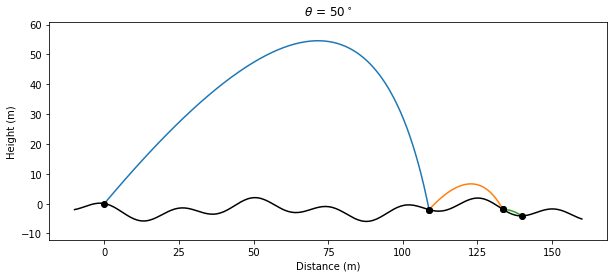

In [7]:
# Plot the ground
x = np.linspace(-10, 160, 300)
hills = Ground(x)
plt.figure(figsize=[10,4])
plt.plot(x,hills, 'k')
plt.axis('equal')

plt.plot(y[:,0], y[:,1])  # Plot ball trajectory
plt.plot([0],[0], 'ko')   # Plot initial ball position
plt.plot(y[-1,0], y[-1,1], 'ko')  # Plot final ball position

plt.title(r'$\theta$ = '+str(theta)+'$^\circ$');
plt.xlabel('Distance (m)')
plt.ylabel('Height (m)');

k = GroundSlope(y[-1][0])
u = np.array([np.sqrt(1 / (1 + k ** 2)), k * np.sqrt(1 / (1 + k ** 2))])  # get the vector u for the flight
U = np.array([k * np.sqrt(1 / (k ** 2 + 1)), - np.sqrt(1 / (k ** 2 + 1))]) # get the vector U for the flight
v = np.array([y[-1][2], y[-1][3]])    # get the velocity vector
V = 0.85 * (sum(v * u) * u - sum(v * U) * U)    # get the new velocity vector
ystart_new = np.array([0., 0., 0., 0.])  # initialize a new vector
ystart_new[0] = y[-1][0]
ystart_new[1] = y[-1][1]
ystart_new[2] = V[0]
ystart_new[3] = V[1]
# calculate and plot the flight
t_new,y_new = MyOde(projectile, [t[-1], 60], ystart_new, h, projectile_events)
plt.plot(y_new[:,0], y_new[:,1])  # Plot ball trajectory
plt.plot(y[-1][0],y[-1][1], 'ko')   # Plot initial ball position
plt.plot(y_new[-1,0], y_new[-1,1], 'ko')  # Plot final ball position



k1 = GroundSlope(y_new[-1][0])
u1 = np.array([np.sqrt(1 / (1 + k1 ** 2)), k1 * np.sqrt(1 / (1 + k1 ** 2))])  # get the vector u for the flight
U1 = np.array([k1 * np.sqrt(1 / (k1 ** 2 + 1)), - np.sqrt(1 / (k1 ** 2 + 1))]) # get the vector U for the flight
v1 = np.array([y_new[-1][2], y_new[-1][3]])    # get the velocity vector
V1 = 0.85 * (sum(v1 * u1) * u1 - sum(v1 * U1) * U1)    # get the new velocity vector
ystart_new1 = np.array([0., 0., 0., 0.])  # initialize a new vector
ystart_new1[0] = y_new[-1][0]
ystart_new1[1] = y_new[-1][1]
ystart_new1[2] = V1[0]
ystart_new1[3] = V1[1]
# calculate and plot the flight
t_new1,y_new1 = MyOde(projectile, [t_new[-1], 90], ystart_new1, h, projectile_events)
plt.plot(y_new1[:,0], y_new1[:,1])  # Plot ball trajectory
plt.plot(y_new[-1][0],y_new[-1][1], 'ko')   # Plot initial ball position
plt.plot(y_new1[-1,0], y_new1[-1,1], 'ko')  # Plot final ball position

In [8]:
print(y_new1[-1][0])    # the ball end at x = 139.87m

139.8696374600829


## (e) Rerun the code

In [9]:
def rerun(theta, S, ini_tspan, h = 0.05, graph = False):
    '''
    Returns the x value where the ball ends, and plots the projectile of the ball based on:
        theta: at which angle the ball is shot
        S: the initial velocity of the ball
        ini_tspan: the tspan for the first flight
        h: step size. Default to be 0.05.
        graph: show the graph if True
    
    effects: plots graph, outputs results
    '''
    theta_rad = theta/180.*np.pi
    yStart = np.array([0, 0, S*np.cos(theta_rad), S*np.sin(theta_rad)])
    
    t,y = MyOde(projectile, tspan, yStart, h, projectile_events)
    
    if graph:
        # Plot the ground
        x = np.linspace(-10, 200, 300)
        hills = Ground(x)
        plt.figure(figsize=[10,4])
        plt.plot(x,hills, 'k')
        plt.axis('equal')

        plt.plot(y[:,0], y[:,1])  # Plot ball trajectory
        plt.plot([0],[0], 'ko')   # Plot initial ball position
        plt.plot(y[-1,0], y[-1,1], 'ko')  # Plot final ball position

        plt.title(r'$\theta$ = '+str(theta)+'$^\circ$');
        plt.xlabel('Distance (m)')
        plt.ylabel('Height (m)');

    k = GroundSlope(y[-1][0])
    u = np.array([np.sqrt(1 / (1 + k ** 2)), k * np.sqrt(1 / (1 + k ** 2))])  # get the vector u for the flight
    U = np.array([k * np.sqrt(1 / (k ** 2 + 1)), - np.sqrt(1 / (k ** 2 + 1))]) # get the vector U for the flight
    v = np.array([y[-1][2], y[-1][3]])    # get the velocity vector
    V = 0.85 * (sum(v * u) * u - sum(v * U) * U)    # get the new velocity vector
    ystart_new = np.array([0., 0., 0., 0.])  # initialize a new vector
    ystart_new[0] = y[-1][0]
    ystart_new[1] = y[-1][1]
    ystart_new[2] = V[0]
    ystart_new[3] = V[1]
    # calculate and plot the flight
    t_new,y_new = MyOde(projectile, [t[-1], 100], ystart_new, h, projectile_events)
    if graph:
        plt.plot(y_new[:,0], y_new[:,1])  # Plot ball trajectory
        plt.plot(y[-1][0],y[-1][1], 'ko')   # Plot initial ball position
        plt.plot(y_new[-1,0], y_new[-1,1], 'ko')  # Plot final ball position



    k1 = GroundSlope(y_new[-1][0])
    u1 = np.array([np.sqrt(1 / (1 + k1 ** 2)), k1 * np.sqrt(1 / (1 + k1 ** 2))])  # get the vector u for the flight
    U1 = np.array([k1 * np.sqrt(1 / (k1 ** 2 + 1)), - np.sqrt(1 / (k1 ** 2 + 1))]) # get the vector U for the flight
    v1 = np.array([y_new[-1][2], y_new[-1][3]])    # get the velocity vector
    V1 = 0.85 * (sum(v1 * u1) * u1 - sum(v1 * U1) * U1)    # get the new velocity vector
    ystart_new1 = np.array([0., 0., 0., 0.])  # initialize a new vector
    ystart_new1[0] = y_new[-1][0]
    ystart_new1[1] = y_new[-1][1]
    ystart_new1[2] = V1[0]
    ystart_new1[3] = V1[1]
    # calculate and plot the flight
    t_new1,y_new1 = MyOde(projectile, [t_new[-1], 200], ystart_new1, h, projectile_events)
    if graph:
        plt.plot(y_new1[:,0], y_new1[:,1])  # Plot ball trajectory
        plt.plot(y_new[-1][0],y_new[-1][1], 'ko')   # Plot initial ball position
        plt.plot(y_new1[-1,0], y_new1[-1,1], 'ko')  # Plot final ball position
    
    
    return y_new1[-1][0]

The angle that has the ball end (on its 3rd ground strike) the furthest horizontal distance from the golf tee is 32.385907035014604, and the distance is 164.1351253930776.


164.1351253930776

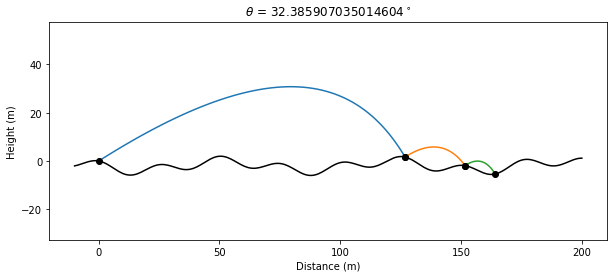

In [10]:
# get the ground slope at x = 0
k = GroundSlope(0)
# try every angle between the ground angle at x = 0 and pi / 2
theta = np.arctan(k) / np.pi * 180
max_x = 0
max_x_angle = theta
while theta < 90:
    this_x = rerun(theta, 58, [0, 60])
    if this_x > max_x:
        max_x = this_x
        max_x_theta = theta
    theta += np.pi / 180

# show the projectile of the angle that has the ball end (on its 3rd ground strike) the furthest horizontal distance from the golf tee
print("The angle that has the ball end (on its 3rd ground strike) the furthest horizontal distance from the golf tee is "\
     + str(max_x_theta) + ", and the distance is " + str(max_x) + ".")
rerun(max_x_theta, 58, [0, 60], graph = True)